In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Homework: Problem 2

a) Implement the forward kinematics and inverse kinematics for a spatial-3R robot shown below. The lengths of the links L1, L2 and L3 are all 1m. The first revolute joint rotates about an axis that is vertical in the plane of the page. The second and third revolute joints rotate about axes that are normal to the page.


b) Implement a PD based trajectory-tracking controller for the robot to track the end-effector trajectories defined by the function 'trajectory(t)' which is implemented in this file. 

c) Provide plots comparing the desired and actual values to show the tracking performance of the controller. Show plots for the joint angles and the end-effector co-ordinates.

<div>
<img src="https://github.com/adityasagi/robotics_tutorial/blob/master/figures/spatial_3R.png?raw=1" width="400">
</div>

In [2]:
!pip install pybullet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%matplotlib inline

###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# Helper functions

def Rx(theta):
  return np.array([[1, 0, 0],
                   [0, np.cos(theta), -np.sin(theta)],
                   [0, np.sin(theta), np.cos(theta)]])

def Ry(theta):
  return np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])

def Rz(theta):
  return np.array([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta), np.cos(theta), 0],
                   [0, 0, 1]])

def t(x,y,z):
  return np.array([[x], [y], [z]])

def zero13():
  return np.array([[0,0,0]])

def one11():
  return np.array([[1]])

def g(R, t):
  return np.vstack([
            np.hstack([R, t]),
            np.hstack([zero13(), one11()])
          ])

def fk_serial2r(theta1, theta2, l1, l2):
  x = l1*np.cos(theta1) + l2*np.cos(theta1 + theta2)
  y = l1*np.sin(theta1) + l2*np.sin(theta1 + theta2)

  return [x,y]

def cosine_rule(a, b, c):
  return np.arccos(np.clip((c**2 + b**2 - a**2)/(2*b*c), -1, 1))

def ik_serial2r(x, y, l1, l2, branch=1):
  r_theta = np.arctan2(y, x) # angle made by radial line w.r.t the reference

  r = (x**2 + y**2)**0.5

  if (r < 1e-3) or ((r > (l1**2 + l2**2)**0.5) and (r < (l1**2 - l2**2)**0.5)): # not in workspace
    return [-1, 0, 0]

  # Ensure the output lies in the range [-PI , PI]
  if r_theta > np.pi:
    r_theta = r_theta - 2*np.pi
  elif r_theta < -np.pi:
    r_theta = r_theta + 2*np.pi
    
  t1 = cosine_rule(l2, r, l1) # internal angle opposite to l2
  t2 = cosine_rule(r, l1, l2) # internal angle opposite to radial line

  theta2 = -(np.pi - t2)

  if branch == 0:
    t1 = -t1
    theta2 = -theta2
  
  theta1 = r_theta + t1

  return [1, theta1, theta2]

In [5]:
#################################################################
# Forward and Inverse kinematics modules for the spatial-3R robot
#################################################################

def forward_kinematics(theta1, theta2, theta3, l1, l2, l3):
    '''
    Forward kinematics module for a spatial-3R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0, 0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- theta3: Relative angle between link l2 and l3 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    --- l3: Lenght of link l3 (in m)
    Ret:
    --- [x, y, z]: Position co-ordinates of the end-effector (in m)
    '''
    
    # WRITE YOUR CODE HERE #
    [x_bar, y_bar] = fk_serial2r(theta2, theta3, l2, l3)

    p_bar = np.array([0, x_bar, y_bar + l1])

    p = Rz(-np.pi/2 + theta1) @ p_bar

    x = p[0]
    y = p[1]
    z = p[2]

    return np.round([x, y, z], 4)

def inverse_kinematics(x, y, z, l1, l2, l3, branch=1):
    '''
    Inverse kinematics modules for the serial-3R manipulator.
    The base of the manipulator is placed at [0,0, 0].    
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- z : Z co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- l3: Length of link l3
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2, theta3]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2, and relative angle between links l2 and l3 respectively.
    '''

    # WRITE YOUR CODE HERE #
    theta1 = np.arctan2(y, x) # we are measuring theta1 from +x axis of base frame!

    r = (x**2 + y**2)**0.5

    p = Rz(theta1).T @ np.array([x, y, z]) - np.array([0,0,l1])

    [valid, theta2, theta3] = ik_serial2r(p[0], p[2], l2, l3, branch)

    return np.round([valid, theta1, theta2, theta3], 4)


In [6]:
# validating the code
l1 = 1.0
l2 = 0.8
l3 = 0.6

theta1 = 0
theta2 = 0
theta3 = 0

[x, y, z] = forward_kinematics(theta1, theta2, theta3, l1, l2, l3)
print([x, y, z])

print('----')

[valid, theta1, theta2, theta3] = inverse_kinematics(x, y, z, l1, l2, l3)

print([valid, theta1, theta2, theta3])

[1.4, 0.0, 1.0]
----
[1.0, 0.0, 0.0, -0.0]


In [7]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = p.connect(p.DIRECT) # or p.GUI


# Load the URDF of the plane that forms the ground
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = p.loadURDF("plane.urdf")


# Load the URDF of the robot
robot = p.loadURDF("/content/drive/MyDrive/Colab Notebooks/spatial_3R_robot.urdf")

In [8]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
p.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
p.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [9]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
p.setJointMotorControl2(robot, 0, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(robot, 1, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(robot, 2, p.VELOCITY_CONTROL, force=0)

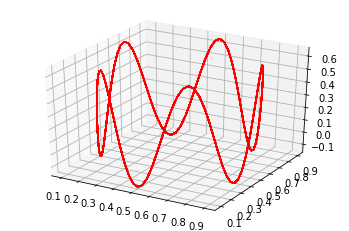

In [10]:
#######################################
# Define functions for the trajectories
#######################################


def trajectory(t):
    '''
    A function to specify the trajectory
    Args:
    t: time
    Returns:
    x: X coordinate of the end-effector
    y: Y coordinate of the end-effector
    z: Z coordinate of the end-effector
    '''
    
    r = 0.4
    a = 0.4
    
    omega = 2*np.pi*2
    omega_z = 2*np.pi*10
    
    # Centre of the trajectory
    [x0, y0, z0] = [0.5, 0.5,0.25]
    
    x = x0 + r*np.cos(omega*t)
    y = y0 + r*np.sin(omega*t)
    z = z0 + a*np.sin(omega_z * t);
    
    return x, y, z


# Plot the trajectory
x_plt = []; y_plt = []; z_plt = []
for t in np.arange(0, 5, 0.005):
    x, y, z = trajectory(t)
    x_plt.append(x)
    y_plt.append(y)
    z_plt.append(z)
        

ax = plt.axes( projection = '3d')
ax.plot3D(x_plt, y_plt, z_plt, 'red')
 
plt.show()

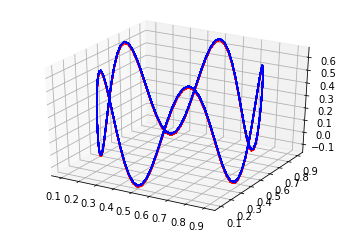

In [11]:
### Testing to check if the ik and fk work
# Plot the trajectory
l1 = 1.0
l2 = 1.0
l3 = 0.8

x_plt = []; y_plt = []; z_plt = []
xb_plt = []; yb_plt = []; zb_plt = []
for t in np.arange(0, 5, 0.005):
    x, y, z = trajectory(t)
    [valid, q1, q2, q3] = inverse_kinematics(x, y, z, l1, l2, l3, 0)
    [xb, yb, zb] = forward_kinematics(q1, q2, q3, l1, l2, l3)

    x_plt.append(x)
    y_plt.append(y)
    z_plt.append(z)

    xb_plt.append(xb)
    yb_plt.append(yb)
    zb_plt.append(zb + 0.01)


ax = plt.axes( projection = '3d')
ax.plot3D(x_plt, y_plt, z_plt, 'red')
ax.plot3D(xb_plt, yb_plt, zb_plt, 'blue')
 
plt.show()

In [12]:
##########################################
# Control loop to follow the trajectory
##########################################

# WRITE YOUR CODE HERE #
Kp = 300
Kd = 5.0

l1 = 1.0
l2 = 1.0
l3 = 0.8

plot_data_q1 = []
plot_data_q2 = []
plot_data_q3 = []

plot_data_q1_d = []
plot_data_q2_d = []
plot_data_q3_d = []

plot_data_x = []
plot_data_y = []
plot_data_z = []

plot_data_xd = []
plot_data_yd = []
plot_data_zd = []

for t in np.arange(0, 5, 0.005):
  x_d, y_d, z_d = trajectory(t)
  plot_data_xd.append(x_d)
  plot_data_yd.append(y_d)
  plot_data_zd.append(z_d)

  [valid, q1_d, q2_d, q3_d] = inverse_kinematics(x_d, y_d, z_d, l1, l2, l3, 0)
  plot_data_q1_d.append(q1_d)
  plot_data_q2_d.append(q2_d)
  plot_data_q3_d.append(q3_d)

  for dt in range(1000):
    Q1 = p.getJointState(robot, 0)
    q1, dq1 = Q1[0], Q1[1]
    Q2 = p.getJointState(robot, 1)
    q2, dq2 = Q2[0], Q2[1]
    Q3 = p.getJointState(robot, 2)
    q3, dq3 = Q3[0], Q3[1]

    tau_fb_1 = Kp*(q1_d - q1) + Kd*(-dq1)
    tau_fb_2 = Kp*(q2_d - q2) + Kd*(-dq2)
    tau_fb_3 = Kp*(q3_d - q3) + Kd*(-dq3)

    p.setJointMotorControlArray(robot, [0,1,2], controlMode=p.TORQUE_CONTROL, forces=[tau_fb_1, tau_fb_2, tau_fb_3])
    p.stepSimulation()

  Q1 = p.getJointState(robot, 0)
  q1, dq1 = Q1[0], Q1[1]
  Q2 = p.getJointState(robot, 1)
  q2, dq2 = Q2[0], Q2[1]
  Q3 = p.getJointState(robot, 2)
  q3, dq3 = Q3[0], Q3[1]

  plot_data_q1.append(q1)
  plot_data_q2.append(q2)
  plot_data_q3.append(q3)

  [x, y, z] = forward_kinematics(q1, q2, q3, l1, l2, l3)

  plot_data_x.append(x)
  plot_data_y.append(y)
  plot_data_z.append(z)

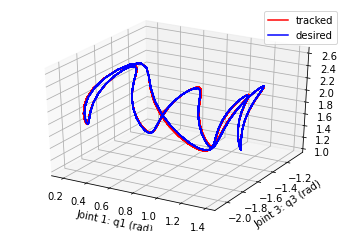

In [13]:
##########################################
# Plot the data in joint-space
##########################################

# WRITE YOUR CODE HERE #

ax = plt.axes( projection = '3d')
ax.plot3D(plot_data_q1, plot_data_q2, plot_data_q3, 'red', label='tracked')
ax.plot3D(plot_data_q1_d, plot_data_q2_d, plot_data_q3_d, 'blue', label='desired')

plt.legend()
plt.xlabel('Joint 1: q1 (rad)')
plt.ylabel('Joint 2: q2 (rad)')
plt.ylabel('Joint 3: q3 (rad)')
plt.show()

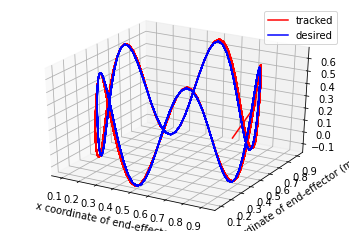

In [14]:
##########################################
# Plot the data in task-space
##########################################

# WRITE YOUR CODE HERE #
ax = plt.axes( projection = '3d')
ax.plot3D(plot_data_x, plot_data_y, plot_data_z, 'red', label='tracked')
ax.plot3D(plot_data_xd, plot_data_yd, plot_data_zd, 'blue', label='desired')

plt.legend()
plt.xlabel('x coordinate of end-effector (m)')
plt.ylabel('y coordinate of end-effector (m)')
plt.ylabel('z coordinate of end-effector (m)')
plt.show()